# Ref
- https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/hello-segmentation/hello-segmentation.ipynb

In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import requests


In [2]:
if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import segmentation_map_to_image, download_file, device_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("hello-segmentation.ipynb")


In [3]:
base_model_dir = Path("./model").expanduser()

model_name = "road-segmentation-adas-0001"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_model_dir / model_xml_name

if not model_xml_path.exists():
    model_xml_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"
    model_bin_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f"{model_name} already downloaded to {base_model_dir}")


road-segmentation-adas-0001 already downloaded to model


In [4]:
# Download the image from the openvino_notebooks storage
image_filename = Path("data/empty_road_mapillary.jpg")


if not image_filename.exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg",
        directory="data",
    )

In [5]:
# --------------- 1. 前処理ユーティリティ ----------------
def load_and_preprocess(image_path: str, input_shape):
    """画像を読み込み、ネットワーク入力形状 (N,C,H,W) に整形して返す"""
    image = cv2.imread(str(image_path))  # BGR
    _, _, H, W = input_shape
    resized = cv2.resize(image, (W, H))  # (W,H)!
    input_blob = np.expand_dims(resized.transpose(2, 0, 1), 0)  # N,C,H,W
    return image, input_blob


# --------------- 2. 推論時間計測関数 ----------------
def benchmark(compiled_model, input_blob, n_iter: int = 20):
    """同期推論を n_iter 回まわして平均処理時間 [ms] を返す"""
    infer_request = compiled_model.create_infer_request()
    # warm‑up
    for _ in range(10):
        infer_request.infer([input_blob])

    start = time.perf_counter()
    for _ in range(n_iter):
        infer_request.infer([input_blob])
    end = time.perf_counter()

    return (end - start) * 1000 / n_iter  # [ms]


# --------------- 3. ベンチマーク比較本体 ----------------
def compare_cpu_vs_npu(
    model_xml_path: str,
    image_path: str,
    n_iter: int = 20,
):
    core = ov.Core()

    # モデルロード（.xml/.bin ペア or .onnx でも可）
    model = core.read_model(model_xml_path)

    # ネットワーク入力形状取得
    input_shape = model.input(0).shape

    # 画像読み込み & 前処理
    _, input_blob = load_and_preprocess(image_path, input_shape)

    results = {}
    for device in ("CPU", "NPU"):
        try:
            compiled = core.compile_model(model, device)
        except RuntimeError as e:
            print(f"[skip] {device} でのコンパイルに失敗しました → {e}")
            continue

        avg_ms = benchmark(compiled, input_blob, n_iter)
        results[device] = avg_ms
        print(f"{device:>3}: {avg_ms:.2f} ms / 推論 (平均, {n_iter} 回)")

    # ------- optional: 可視化 -------
    if len(results) > 1:
        plt.figure()
        plt.bar(results.keys(), results.values())
        plt.ylabel("Latency [ms] (lower is better)")
        plt.title(f"Inference latency comparison\n(n_iter={n_iter})")
        for dev, ms in results.items():
            plt.text(dev, ms, f"{ms:.1f} ms", ha="center", va="bottom")
        plt.show()

CPU: 9.65 ms / 推論 (平均, 100 回)
NPU: 26.83 ms / 推論 (平均, 100 回)


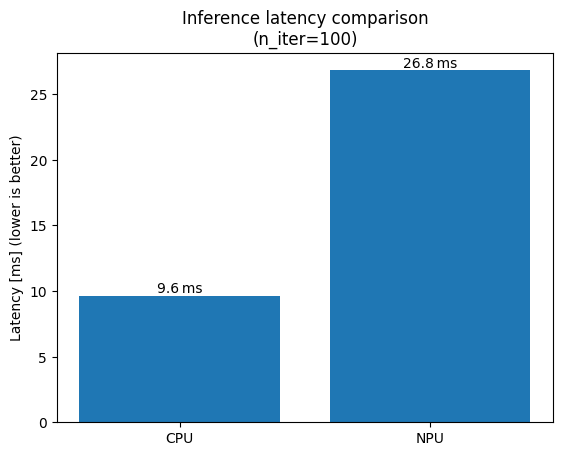

In [6]:
compare_cpu_vs_npu(model_xml_path=model_xml_path, image_path=image_filename, n_iter=100)